## 9.2 微调

1. **迁移学习(transfer learning)**
    - 该数据集上训练的模型可以抽取较通用的图像特征，从而能够帮助识别边缘、纹理、形状和物体组成
    - 迁移学习中的一种常用技术: 微调


2. **微调(fine tuning)**
    - 在源数据集（如ImageNet数据集）上预训练一个神经网络模型，即源模型
    - 创建一个新的神经网络模型，即目标模型
        - 复制了源模型上除了输出层外的所有模型设计及其参数
        - 假设这些模型参数包含了源数据集上学习到的知识，且这些知识同样适用于目标数据集
        - 还假设源模型的输出层跟源数据集的标签紧密相关，因此在目标模型中不予采用
    - 为目标模型添加一个输出大小为目标数据集类别个数的输出层，并随机初始化该层的模型参数
    - 目标数据集上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的

![微调](img/9.2_finetune.svg)

### 9.2.1 热狗识别

1. torchvision的[models](https://pytorch.org/docs/stable/torchvision/models.html)包提供了常用的预训练模型
2. 更多的预训练模型，可以使用使用[pretrained-models](https://github.com/Cadene/pretrained-models.pytorch)仓库

In [1]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os

import sys
sys.path.append("..") 
import d2lzh_pytorch.utils as d2l

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 9.2.1.1 获取数据集

1. 该数据集含有1400张包含热狗的正类图像，和同样多包含其他食品的负类图像
2. 各类的1000张图像被用于训练，其余则用于测试

In [2]:
data_dir = '~/Datasets/'
data_dir = os.path.expanduser(data_dir)
os.listdir(os.path.join(data_dir, "hotdog"))

['test', 'train']

`ImageFolder`实例来分别读取训练数据集和测试数据集中的所有图像文件

In [3]:
train_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/train'))
test_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/test'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026097AA8748>,
      dtype=object)

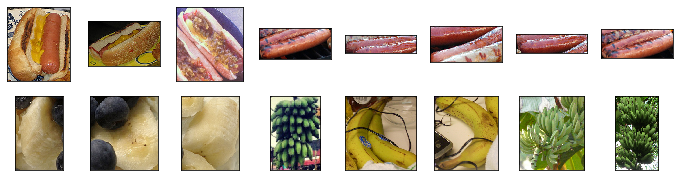

In [4]:
# 前八张正类
hotdots = [train_imgs[i][0] for i in range(8)]
# 后八张负类
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdots + not_hotdogs, 2, 8, scale=1.5)

- 训练
    - 先从图像中裁剪出随机大小和随机高宽比的一块随机区域，
    - 然后将该区域缩放为高和宽均为224像素的输入
- 测试
    - 时，我们将图像的高和宽均缩放为256像素
    - 然后从中裁剪出高和宽均为224像素的中心区域作为输入
- 标准化
    - 对RGB（红、绿、蓝）三个颜色通道的数值做标准化：每个数值减去该通道所有数值的平均值，再除以该通道所有数值的标准差作为输出
    
***在使用预训练模型时，一定要和预训练时作同样的预处理***

```
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
```

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_augs = transforms.Compose([
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

test_augs = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    normalize
])

#### 9.2.1.2 定义和初始化模型

> 不管你是使用的torchvision的models还是pretrained-models.pytorch仓库，默认都会将预训练好的模型参数下载到你的home目录下.cache/torch/checkpoint文件夹。你可以通过修改环境变量`TORCH_MODEL_ZOO`来更改下载目录(windows环境)

> 可直接手动下载,然后放入上面目录中

In [6]:
pretrained_net = models.resnet18(pretrained=True)

In [7]:
# 作为一个全连接层，它将ResNet最终的全局平均池化层输出变换成ImageNet数据集上1000类的输出
print(pretrained_net.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [8]:
# 修改需要的输出类别数
pretrained_net.fc = nn.Linear(512, 2)
print(pretrained_net.fc)

Linear(in_features=512, out_features=2, bias=True)


1. **此时，pretrained_net的fc层就被随机初始化了，但是其他层依然保存着预训练得到的参数**
2. **由于是在很大的ImageNet数据集上预训练的，所以参数已经足够好，因此一般只需使用较小的学习率来微调这些参数**
3. **而fc中的随机初始化参数一般需要更大的学习率从头训练**

In [9]:
# 将fc的学习率设为已经预训练过的部分的10倍
output_params = list(map(id, pretrained_net.fc.parameters()))
feature_params = filter(lambda p: id(p) not in output_params, pretrained_net.parameters())

lr = 0.01
optimizer = optim.SGD([{'params': feature_params},
                      {'params': pretrained_net.fc.parameters(), 'lr': lr * 10}],
                     lr=lr, weight_decay=0.001)

#### 9.2.1.3 微调模型

In [10]:
def train_fine_tuning(net, optimizer, batch_size=8, num_epochs=5):
    train_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/train'), transform=train_augs), 
                           batch_size, shuffle=True)
    test_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/test'), transform=test_augs),
                          batch_size)
    
    loss = torch.nn.CrossEntropyLoss()
    d2l.train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

In [ ]:
train_fine_tuning(pretrained_net, optimizer)

training on  cpu
epoch 1, loss 2.6333, train acc 0.718, test acc 0.854, time 623.1 sec
epoch 2, loss 0.7052, train acc 0.750, test acc 0.851, time 600.2 sec
epoch 3, loss 0.2392, train acc 0.801, test acc 0.882, time 610.1 sec


> 作为对比，我们定义一个相同的模型，但将它的所有模型参数都初始化为随机值。由于整个模型都需要从头训练，我们可以使用较大的学习率

In [ ]:
scratch_net = models.resnet18(pretrained=False, num_classes=2)
lr = 0.1
optimizer = optim.SGD(scratch_net.parameters(), lr=lr, weight_decay=0.001)
train_fine_tuning(scratch_net, optimizer)